# Capstone: Epidemic propagation

## Objectives
Can you run a simple spatial-temporal clustering of recent historic epidemics, and can this give you the next epidemics?

Can you pull in some main socio-economic features of the centroids of these clusters and run PCA to see the commonalities across these. What do we predict through this?

Can you include propagation of epidemics and see how they spread?

Therefore... 
Is the Coronavirus predictable?
Where's the next one, and how will that spread?
    
## Data required:
1. List of all recent epidemics (with location and year), including: SARS, Coronavirus, MERS, Ebola, Zika, Bird Flu
2. Socio-economic data for each virus: Long / Lat, Population, Development index, cleanliness etc.?
3. Epidemic propagation: airport traffic at each infected city, volume of travel between cities affected

In [3]:
# Epidemics list:

epidemics_list = pd.read_csv('epidemics_list.csv')

epi_interest = ['SARS coronavirus',
                'Ebola',
                'Middle East respiratory disease',
                'Zika virus',
                'Novel coronavirus (2019-nCoV)']

# what do I want for each?
# date, city, country, long/lat, no. confirmed cases
epidemics_list.Disease.unique()
epidemics_list[epidemics_list['Disease'].isin(['Ebola','Ebola virus disease\n\nEbola virus virion'])]
epidemics_list[epidemics_list['Disease'].isin(['SARS coronavirus'])]

epidemics_list

,Death toll (estimate),Location,Date,Event,Disease
0,NaN,Nigeria,2001,NaN,Cholera
1,NaN,South Africa,2001,NaN,Cholera
2,299,Hong Kong,2002–2004,Timeline of the SARS outbreak,SARS coronavirus
3,349,China,2002–2004,Timeline of the SARS outbreak,SARS coronavirus
4,NaN,Algeria,2003,NaN,Plague
5,NaN,Afghanistan,2004,NaN,Leishmaniasis
6,NaN,Bangladesh,2004,NaN,Cholera
7,NaN,Indonesia,2004,NaN,Dengue fever
8,NaN,Senegal,2004,NaN,Cholera
9,NaN,Sudan,2004,NaN,Ebola


In [1]:
import pandas as pd
pd.set_option('display.max_rows',1000, 'display.max_columns',100, 'display.max_colwidth',1000)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import glob
import os
from geopy.geocoders import Nominatim

In [2]:
# Ebola_Sierra Leone import:
path = r'ebola-master/sl_data'
filenames = glob.glob(path + "/*.csv")

inner = []

for filename in filenames:
    inner.append(pd.read_csv(filename, index_col=None, header=0))
    
ebola_sl = pd.concat(inner, ignore_index=True)

/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [3]:
ebola_sl.variable.unique()

array(['population', 'new_noncase', 'new_suspected', 'new_probable',
       'new_confirmed', 'cum_noncase', 'cum_suspected', 'cum_probable',
       'cum_confirmed', 'death_suspected', 'death_probable',
       'death_confirmed', 'cfr', 'etc_new_admission',
       'etc_currently_admitted', 'etc_cum_admission', 'etc_new_deaths',
       'etc_cum_deaths', 'etc_new_discharges', 'etc_cum_discharges',
       'cum_contacts', 'cum_completed_contacts', 'contacts_followed',
       'new_contacts', 'contacts_healthy', 'contacts_ill',
       'contacts_not_seen', 'new_completed_contacts', 'percent_seen',
       'total_lab_samples', 'repeat_samples', 'new_samples',
       'new_positive', 'new_negative', 'pending', 'positive_corpse',
       'negative_corpse'], dtype=object)

In [4]:
# Data Cleaning:

# Retrieving S,I,R variables:
ebola_sl_sir = ebola_sl[(ebola_sl['variable']=='population')|
                             (ebola_sl['variable']=='cum_confirmed')|
                             (ebola_sl['variable']=='cum_suspected')|
                             (ebola_sl['variable']=='cum_probable')|
                             (ebola_sl['variable']=='death_confirmed')|
                             (ebola_sl['variable']=='death_suspected')|
                             (ebola_sl['variable']=='death_probable')]
ebola_sl_sir.dropna(axis=1, inplace=True, how='all')
ebola_sl_sir.dropna(inplace=True, how='all', subset=ebola_sl_sir.columns[0:8])
ebola_sl_sir['date'] = pd.to_datetime(ebola_sl_sir['date'], format='%Y-%m-%d')
ebola_sl_sir.sort_values('date',inplace=True)
ebola_sl_sir.replace({',': ''}, regex=True, inplace=True)
ebola_sl_sir.loc[:,'Bo':'Western area urban'] = ebola_sl_sir.loc[:,'Bo':'Western area urban'].apply(pd.to_numeric)

# Checking that the sums make sense, making sure National is indeed sum of cities. Also understand what Western 
# areas are (many NaNs here):ebola_sl_new['manual_sum'] = ebola_sl_new[col_list].sum(axis=1)
col_list = list(ebola_sl_sir.columns[0:16])
col_list.remove('National')
ebola_sl_sir['manual_sum'] = ebola_sl_sir[col_list].sum(axis=1)
ebola_sl_sir['check'] = ebola_sl_sir.National == ebola_sl_sir.manual_sum
ebola_sl_sir['diff'] = ebola_sl_sir.National - ebola_sl_sir.manual_sum
ebola_sl_sir.check.value_counts()

# Looking at these newly created check and diff columns, I will:
    # where National = NaN, override National with the manual_sum
    # override 'Western area' with National - sum(other regions), will later remove rural and urban subsets
col_list_2 = list(ebola_sl_sir.columns[0:13])
col_list_2.remove('National')
ebola_sl_sir['National'].fillna(ebola_sl_sir['manual_sum'],inplace=True)
ebola_sl_sir['Western area'] = ebola_sl_sir['National'] - ebola_sl_sir[col_list_2].sum(axis=1)

# Then use melt to arrange city columns into rows, and remove the unecessary columns:
ebola_sl_sir = ebola_sl_sir.melt(id_vars=['date','variable'],
                                 value_vars=['Bo', 'Bombali', 'Bonthe', 'Kailahun', 'Kambia', 'Kenema', 'Koinadugu', 'Kono', 'Moyamba', 'Port Loko', 'Pujehun', 'Tonkolili', 'Western area'],
                                 var_name='city', value_name='cum_count')
ebola_sl_sir.insert(2,'country','Sierra Leone')
ebola_sl_sir_map = {'cum_confirmed':'infected',
                    'cum_suspected':'infected',
                    'cum_probable':'infected',
                    'death_confirmed':'removed',
                    'death_suspected':'removed',
                    'death_probable':'removed',
                    'population':'susceptible'}

ebola_sl_sir.insert(1, 'SIR_group', ebola_sl_sir['variable'].map(ebola_sl_sir_map))
ebola_sl_sir = ebola_sl_sir[(ebola_sl_sir['cum_count']>=0)&((ebola_sl_sir['cum_count']<1000))]

# Latitude and Longitude:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='noah.berhe@gmail.com', timeout=3)

sl_geolocations = {}
for place in ebola_sl_sir.city.unique():
    sl_geolocations[str(place)] = geolocator.geocode("{}, Sierra Leone".format(place))
sl_geolocations

ebola_sl_sir.insert(5,'latitude',[sl_geolocations[str(place)].latitude for place in ebola_sl_sir.city])
ebola_sl_sir.insert(6,'longitude',[sl_geolocations[str(place)].longitude for place in ebola_sl_sir.city])

/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

In [9]:
geolocator.geocode('E1 1NY')

GeocoderTimedOut: Service timed out

In [7]:
ebola_sl_sir_2 = ebola_sl_sir.groupby(['date','SIR_group','country','city','latitude','longitude'],as_index=False).sum()

In [8]:
ebola_sl_sir_2.head()

,date,SIR_group,country,city,latitude,longitude,cum_count
0,2014-08-12,infected,Sierra Leone,Bo,7.962065,-11.736650,25.0
1,2014-08-12,infected,Sierra Leone,Bombali,9.238837,-12.114802,9.0
2,2014-08-12,infected,Sierra Leone,Bonthe,7.529277,-12.513187,1.0
3,2014-08-12,infected,Sierra Leone,Kailahun,8.277001,-10.573943,410.0
4,2014-08-12,infected,Sierra Leone,Kambia,9.124685,-12.918913,1.0


In [10]:
ebola_sl_sir_2.shape

(2520, 7)

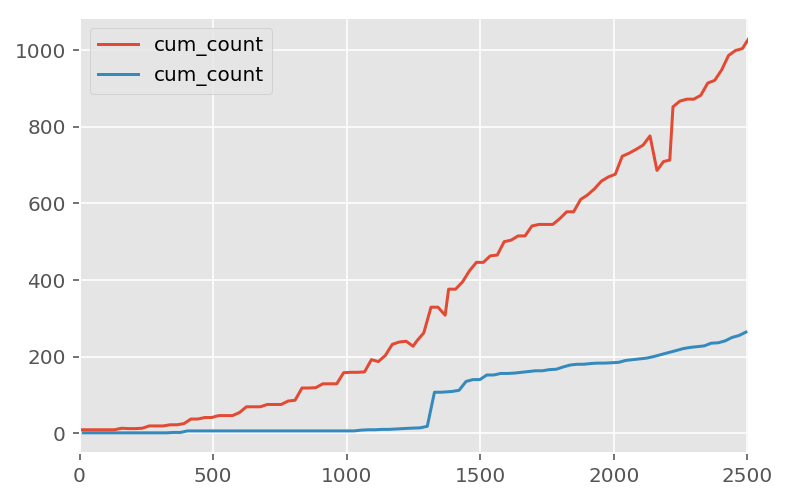

In [9]:
ebola_sl_sir_2[(ebola_sl_sir_2['city']=='Bombali')&(ebola_sl_sir_2['SIR_group']=='infected')]['cum_count'].plot()
ebola_sl_sir_2[(ebola_sl_sir_2['city']=='Bombali')&(ebola_sl_sir_2['SIR_group']=='removed')]['cum_count'].plot()
plt.legend()

In [ ]:
# Ebola Guinea:



In [171]:
# CHRISTOPHE ADVICE:

# incubation period... speed of sufferance / deaths, how easy to affect, ebola was over easy.
# feature-based analysis... 
# diffusion simulation

# 1. Once data for Ebola has been collected, put country into a column and cities into another, then you can add
    # longitude / latitude column.
# 2. Then research how to simulate the diffusion of Ebola... maybe a bit of Brownian / Monte Carlo?

In [175]:
ebola_guinea.head()

,Beyla,Boffa,Conakry,Coyah,Dabola,Dalaba,Date,Description,Dinguiraye,Dubreka,Forecariah,Gueckedou,Kerouane,Kindia,Kissidougou,Kouroussa,Lola,Macenta,Mzerekore,Nzerekore,Pita,Siguiri,Telimele,Totals,Yomou
0,NaN,0,5,NaN,0,NaN,2014-08-04,New cases of suspects,0,0,NaN,0,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,5,NaN
1,NaN,0,0,NaN,0,NaN,2014-08-04,New cases of probables,0,0,NaN,0,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,0,NaN
2,NaN,0,1,NaN,0,NaN,2014-08-04,New cases of confirmed,0,0,NaN,3,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,4,NaN
3,NaN,0,6,NaN,0,NaN,2014-08-04,Total new cases registered so far,0,0,NaN,3,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,9,NaN
4,NaN,0,9,NaN,0,NaN,2014-08-04,Total cases of suspects,0,0,NaN,2,NaN,NaN,0,0,NaN,0,NaN,0,0,0,0,11,NaN


In [229]:
# Implementing SIR:
import scipy.integrate
import numpy
import matplotlib.pyplot as plt

In [230]:
# ODEs
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return([dS_dt, dI_dt, dR_dt])

In [480]:
# Initial conditions
S0 = 0.9
I0 = 0.1
R0 = 0.0
beta = 0.35
gamma = 0.1

# Time vector
t = numpy.linspace(0, 100, 10000)

# Result
solution = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
solution = numpy.array(solution)

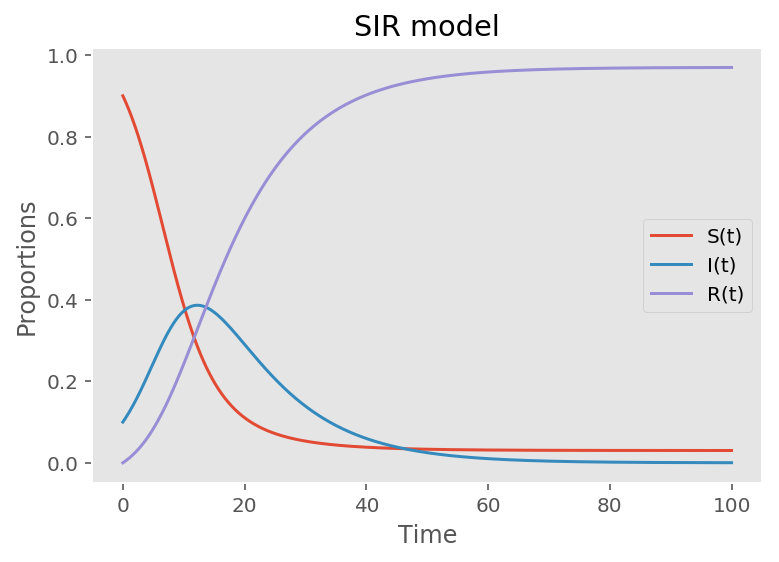

In [481]:
# Plot result
plt.figure(figsize=(6,4))
plt.plot(t, solution[:,0], label='S(t)')
plt.plot(t, solution[:,1], label='I(t)')
plt.plot(t, solution[:,2], label='R(t)')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Proportions')
plt.title('SIR model')
plt.show()